# Data Loader 
This cells in this file wil load each of the datasets and then save then as numpy arrays in the same folder that the og data was found in.  
  
Ideally this should be run once.

#### Imports

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
np.set_printoptions(threshold=np.inf, linewidth=np.inf)


#### Data loader
Now anytime you want to grab the data run `np.load("path/to/file.npy")`

In [4]:
fiveFiftyPath = r"..\..\5_mr_50_cond\simulated_noNoise.txt"
fourtyFiftyPath = r"..\..\40_mr_50_cond\simulated_noNoise.txt"
hundidHundidPath = r"..\..\100_mr_100_cond\simulated_noNoise.txt"


data_5_mr_50_cond = np.loadtxt(fiveFiftyPath)
np.save(r"..\..\5_mr_50_cond\simulated_noNoiseAll", data_5_mr_50_cond)
data_5_mr_50_cond_tfs = data_5_mr_50_cond[1:,:100]
np.save(r"..\..\5_mr_50_cond\simulated_noNoiseTFs", data_5_mr_50_cond_tfs)
data_5_mr_50_cond_tgs = data_5_mr_50_cond[1:,100:200]
np.save(r"..\..\5_mr_50_cond\simulated_noNoiseTGs", data_5_mr_50_cond_tgs)

data_40_mr_50_cond = np.loadtxt(fourtyFiftyPath)
np.save(r"..\..\40_mr_50_cond\simulated_noNoiseAll", data_40_mr_50_cond)
data_40_mr_50_cond_tfs = data_40_mr_50_cond[1:,:100]
np.save(r"..\..\40_mr_50_cond\simulated_noNoiseTFs", data_40_mr_50_cond_tfs)
data_40_mr_50_cond_tgs = data_40_mr_50_cond[1:,100:200]
np.save(r"..\..\40_mr_50_cond\simulated_noNoiseTGs", data_40_mr_50_cond_tgs)

data_100_mr_100_cond = np.loadtxt(hundidHundidPath)
np.save(r"..\..\100_mr_100_cond\simulated_noNoiseAll", data_100_mr_100_cond)
data_100_mr_100_cond_tfs = data_100_mr_100_cond[1:,:100]
np.save(r"..\..\100_mr_100_cond\simulated_noNoiseTFs", data_100_mr_100_cond_tfs)
data_100_mr_100_cond_tgs = data_100_mr_100_cond[1:,100:200]
np.save(r"..\..\100_mr_100_cond\simulated_noNoiseTGs", data_100_mr_100_cond_tgs)



Normalized Target Genes and TFs for 100 MR, 40 MR, and 5 MR


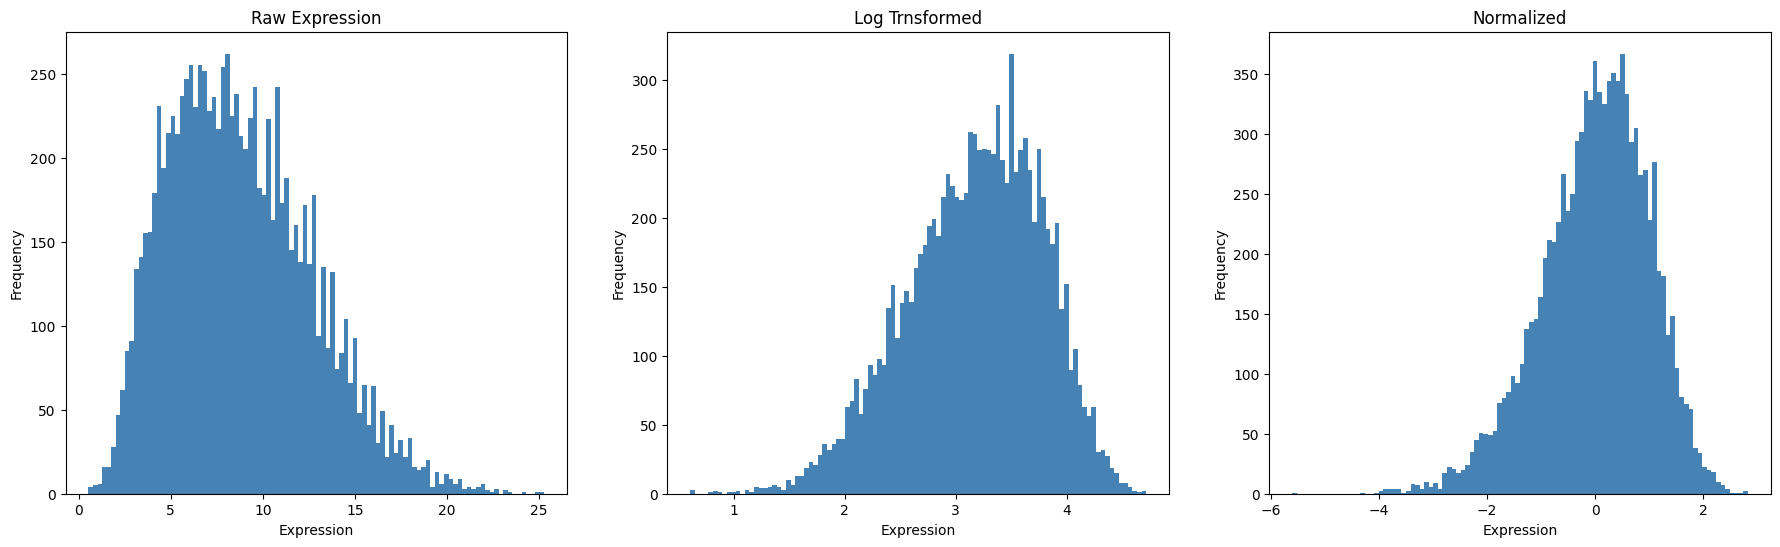

In [26]:

# Load ground truth
ground_truth_path_100mr_100cond = "../../100_mr_100_cond/bipartite_GRN.csv"
ground_truth = pd.read_csv(ground_truth_path_100mr_100cond, header=None).values

ground_truth_path_40mr = "../../40_mr_50_cond/bipartite_GRN.csv"
ground_truth40 = pd.read_csv(ground_truth_path_40mr, header=None).values

ground_truth_path_5mr = "../../5_mr_50_cond/bipartite_GRN.csv"
ground_truth5 = pd.read_csv(ground_truth_path_5mr, header=None).values

## Log Normalization
data_100_mr_100_cond_tfs_LOG = np.log2(data_100_mr_100_cond_tfs + 1)
data_100_mr_100_cond_tgs_LOG = np.log2(data_100_mr_100_cond_tgs + 1)

data_5_mr_50_cond_tfs_LOG = np.log2( data_5_mr_50_cond_tfs+ 1)
data_5_mr_50_cond_tgs_LOG = np.log2(data_5_mr_50_cond_tgs+1)

data_40_mr_50_cond_tfs_LOG = np.log2(data_40_mr_50_cond_tfs+1)
data_40_mr_50_cond_tgs_LOG = np.log2(data_40_mr_50_cond_tgs+1)


## Transform features to zero mean, 1 stdev
scaler = StandardScaler()

tf_100mr_normalized = scaler.fit_transform(data_100_mr_100_cond_tfs_LOG)
tg_100mr_nomralized = scaler.fit_transform(data_100_mr_100_cond_tgs_LOG)

tf_40mr_normalized = scaler.fit_transform(data_40_mr_50_cond_tfs_LOG)
tg_40mr_normalized = scaler.fit_transform(data_40_mr_50_cond_tgs_LOG)

tf_5mr_normalized = scaler.fit_transform(data_5_mr_50_cond_tfs_LOG)
tg_5mr_normalized = scaler.fit_transform(data_5_mr_50_cond_tgs_LOG)

print("Normalized Target Genes and TFs for 100 MR, 40 MR, and 5 MR")

fig, axs = plt.subplots(1, 3, figsize=(22, 6))

axs[0].hist(data_100_mr_100_cond_tgs.flatten(), bins=100, color='steelblue')
axs[0].set_title('Raw Expression')
axs[0].set_xlabel('Expression')
axs[0].set_ylabel('Frequency')

axs[1].hist(data_100_mr_100_cond_tgs_LOG.flatten(), bins=100, color='steelblue')
axs[1].set_title('Log Trnsformed')
axs[1].set_xlabel('Expression')
axs[1].set_ylabel('Frequency')

axs[2].hist(tg_100mr_nomralized.flatten(), bins=100, color='steelblue')
axs[2].set_title('Normalized')
axs[2].set_xlabel('Expression')
axs[2].set_ylabel('Frequency')
plt.show()


#### Training

In [ ]:
def train_random_forests(tf_expression, target_expression, n_estimators=1000):
    
    models = []
    
    for i in range(target_expression.shape[1]):
        rf = RandomForestRegressor(n_estimators=n_estimators, bootstrap=True, random_state=42)
        rf.fit(tf_expression, target_expression[:, i])
        models.append(rf)
        if i%10==0:
            print(f"Trined model {i+1} out of {target_expression.shape[1]}")
    return models

# Train models
models_100mr = train_random_forests(tf_100mr_normalized, tg_100mr_nomralized)
models_40mr = train_random_forests(tf_40mr_normalized, tg_40mr_normalized)
models_5mr = train_random_forests(tf_5mr_normalized, tg_5mr_normalized)


Trined model 1 out of 100
Trined model 11 out of 100
Trined model 21 out of 100
Trined model 31 out of 100
Trined model 41 out of 100
Trined model 51 out of 100
Trined model 61 out of 100
Trined model 71 out of 100
Trined model 81 out of 100
Trined model 91 out of 100
Trined model 1 out of 100
Trined model 11 out of 100
Trined model 21 out of 100
Trined model 31 out of 100
Trined model 41 out of 100
Trined model 51 out of 100
Trined model 61 out of 100
Trined model 71 out of 100
Trined model 81 out of 100
Trined model 91 out of 100
Trined model 1 out of 100
Trined model 11 out of 100
Trined model 21 out of 100
Trined model 31 out of 100
Trined model 41 out of 100
Trined model 51 out of 100
Trined model 61 out of 100
Trined model 71 out of 100
Trined model 81 out of 100
Trined model 91 out of 100


In [21]:
def train_extra_trees(tf_expression, target_expression, n_estimators=1000):
    
    models = []
    
    for i in range(target_expression.shape[1]):
        et = ExtraTreesRegressor(n_estimators=n_estimators, bootstrap=False, random_state=42)
        et.fit(tf_expression, target_expression[:, i])
        models.append(et)
        if i%10 == 0:
            print(f"Trined model {i+1} out of {target_expression.shape[1]}")
    return models

# Train models
models_100mr_et = train_extra_trees(tf_100mr_normalized, tg_100mr_nomralized)
models_40mr_et = train_extra_trees(tf_40mr_normalized, tg_40mr_normalized)
models_5mr_et = train_extra_trees(tf_5mr_normalized, tg_5mr_normalized)

Trined model 1 out of 100
Trined model 11 out of 100
Trined model 21 out of 100
Trined model 31 out of 100
Trined model 41 out of 100
Trined model 51 out of 100
Trined model 61 out of 100
Trined model 71 out of 100
Trined model 81 out of 100
Trined model 91 out of 100
Trined model 1 out of 100
Trined model 11 out of 100
Trined model 21 out of 100
Trined model 31 out of 100
Trined model 41 out of 100
Trined model 51 out of 100
Trined model 61 out of 100
Trined model 71 out of 100
Trined model 81 out of 100
Trined model 91 out of 100
Trined model 1 out of 100
Trined model 11 out of 100
Trined model 21 out of 100
Trined model 31 out of 100
Trined model 41 out of 100
Trined model 51 out of 100
Trined model 61 out of 100
Trined model 71 out of 100
Trined model 81 out of 100
Trined model 91 out of 100


In [22]:
def get_feature_importance_matrix(models):
    
    n_tfs = 100
    n_targets = 100
    
    importance_matrix = np.zeros((n_tfs, n_targets))
    
    ## The column is feature importances for a specific gene, rows correspond to each gene
    for i, model in enumerate(models):
        importance_matrix[:, i] = model.feature_importances_
        
    return importance_matrix


# Get importance matrix
importance_matrix = get_feature_importance_matrix(models_100mr)
importance_matrix_rf_40mr = get_feature_importance_matrix(models_40mr)
importance_matrix_rf_5mr = get_feature_importance_matrix(models_5mr)

importance_matrix_et = get_feature_importance_matrix(models_100mr_et)
importance_matrix_et_40mr = get_feature_importance_matrix(models_40mr_et)
importance_matrix_et_5mr = get_feature_importance_matrix(models_5mr_et)
# Normalize_importance_matrix with respect to columns (columns are genes, rows are TFs, cells are importance scores):

ranked_scores = {}
for gene_index in range(importance_matrix.shape[1]):
    scores = importance_matrix[:, gene_index]
    ## Create list of tuples
    tf_scores = [(tf_index, score) for tf_index, score in enumerate(scores)]
    ranked_tf_scores = sorted(tf_scores, key=lambda x: x[1], reverse=True)
    ranked_scores[gene_index + 100] = ranked_tf_scores  # Gene indices are 100-199

#for i in range(100):
    #print(f"Gene {i+100}: {ranked_scores[i+100]}")



### Calculate AUROC Scores

In [24]:
from sklearn.metrics import roc_auc_score

def create_adjacency_matrix(edge_list, n_tfs, n_targets):
    adj_matrix = np.zeros((n_tfs, n_targets))
    for tf, target in edge_list:
        adj_matrix[int(tf), int(target-100)] = 1
    return adj_matrix

def get_auc_scores(importance, gt):
    aucs = np.zeros((100,1))
    for i in range(100):
        gt_i = gt[:,i]
        importance_i = importance[:,i]
        aucs[i] = roc_auc_score(gt_i, importance_i)

    return(aucs)



ground_truth_matrix = create_adjacency_matrix(ground_truth, 100, 100)
ground_truth_matrix40mr = create_adjacency_matrix(ground_truth40, 100,100)
ground_truth_matrix5mr = create_adjacency_matrix(ground_truth5, 100, 100)
auc_scores = get_auc_scores(importance_matrix, ground_truth_matrix)
auc_scores_ets = get_auc_scores(importance_matrix_et, ground_truth_matrix)

auc_rf_40 = get_auc_scores(importance_matrix_rf_40mr, ground_truth_matrix40mr)
auc_rf_5 = get_auc_scores(importance_matrix_rf_5mr, ground_truth_matrix5mr)
auc_et_40 = get_auc_scores(importance_matrix_et_40mr, ground_truth_matrix40mr)
auc_et_5 = get_auc_scores(importance_matrix_et_5mr, ground_truth_matrix5mr)

print(f"Average AUROC Score 100 mr: {np.mean(auc_scores)}")
print(f"Average AUROC Score et 100 mr: {np.mean(auc_scores_ets)}")
print(f"Average AUROC Score 40 mr: {np.mean(auc_rf_40)}")
print(f"Average AUROC Score et 40 mr ET: {np.mean(auc_et_40)}")
print(f"Average AUROC Score 5 mr: {np.mean(auc_rf_5)}")
print(f"Average AUROC Score et 5 mr: {np.mean(auc_et_5)}")
print(auc_scores_ets.T)
print(auc_scores.T)

Average AUROC Score 100 mr: 0.9092807496391422
Average AUROC Score et 100 mr: 0.9130154045395968
Average AUROC Score 40 mr: 0.8438299701435311
Average AUROC Score et 40 mr ET: 0.8448011792302901
Average AUROC Score 5 mr: 0.6720637437928454
Average AUROC Score et 5 mr: 0.6909773034072002
[[0.97263158 0.97250859 0.89684211 0.96631579 0.88297872 0.85407066 0.97395833 0.99789474 0.79723502 1.         0.95391705 0.84639017 1.         0.97052632 0.89690722 0.94105263 0.8046875  0.86524823 0.81914894 0.79432624 1.         1.         0.98969072 0.95035461 0.98281787 0.90721649 0.96099291 0.99656357 0.984375   0.97916667 0.87157895 1.         0.73263158 0.984375   0.73758865 0.95852535 0.90736842 0.98315789 0.86021505 0.93684211 0.8        0.74961598 0.85106383 0.69072165 0.96210526 0.87403994 0.82334869 0.79427083 0.94148936 0.77304965 0.99312715 0.97473684 0.91397849 1.         0.95833333 0.83156028 0.99312715 0.85263158 0.89554531 0.8046875  0.98958333 0.99578947 0.99479167 1.         0.9947

In [ ]:
def reconstruct_network(importance_matrix, threshold):
    """Reconstruct network using importance threshold.
    
    Args:
        importance_matrix: Matrix of feature importance scores
        threshold: Threshold for considering a connection
        
    Returns:
        Binary adjacency matrix
    """
    return (importance_matrix > threshold).astype(int)

def create_adjacency_matrix(edge_list, n_tfs, n_targets):
    adj_matrix = np.zeros((n_tfs, n_targets))
    for tf, target in edge_list:
        adj_matrix[int(tf), int(target-100)] = 1
    return adj_matrix

def evaluate_network(predicted, ground_truth):
    
    n_tfs, n_targets = predicted.shape
    ground_truth_matrix = create_adjacency_matrix(ground_truth, n_tfs, n_targets)
    
    # Calculate binary metrics
    precision = precision_score(ground_truth_matrix.flatten(), predicted.flatten())
    recall = recall_score(ground_truth_matrix.flatten(), predicted.flatten())
    f1 = f1_score(ground_truth_matrix.flatten(), predicted.flatten())
    
    # Calculate AUROC
    fpr, tpr, _ = roc_curve(ground_truth_matrix.flatten(), predicted.flatten())
    auroc = auc(fpr, tpr)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auroc,
        'fpr': fpr,
        'tpr': tpr
    }
# Try different thresholds
thresholds = np.linspace(0, 1, 100)
metrics_100mr = []
ground_truth_matrix = create_adjacency_matrix(ground_truth, 100, 100)
print(np.sum(ground_truth_matrix, axis=0))

# metrics_100mr is a list of dictionaries
for threshold in thresholds:
    predicted_network = reconstruct_network(importance_matrix, threshold)
    metric = evaluate_network(predicted_network, ground_truth)
    metric['threshold'] = threshold
    metrics_100mr.append(metric)


metrics_df = pd.DataFrame(metrics_100mr)
print(metrics_df)



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

    precision    recall        f1     auroc  \
0    0.048700  1.000000  0.092877  0.500000   
1    0.155481  0.856263  0.263175  0.809084   
2    0.544974  0.634497  0.586338  0.803688   
3    0.818505  0.472279  0.598958  0.733459   
4    0.942529  0.336756  0.496218  0.667852   
..        ...       ...       ...       ...   
95   0.000000  0.000000  0.000000  0.500000   
96   0.000000  0.000000  0.000000  0.500000   
97   0.000000  0.000000  0.000000  0.500000   
98   0.000000  0.000000  0.000000  0.500000   
99   0.000000  0.000000  0.000000  0.500000   

                                  fpr                              tpr  \
0                          [0.0, 1.0]                       [0.0, 1.0]   
1     [0.0, 0.23809523809523808, 1.0]   [0.0, 0.8562628336755647, 1.0]   
2    [0.0, 0.027120782087669507, 1.0]   [0.0, 0.6344969199178645, 1.0]   
3    [0.0, 0.005361084831283507, 1.0]   [0.0, 0.4722792607802875, 1.0]   
4   [0.0, 0.0010511931041732366, 1.0]  [0.0, 0.33675564681724846,

c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

#### Plotting 

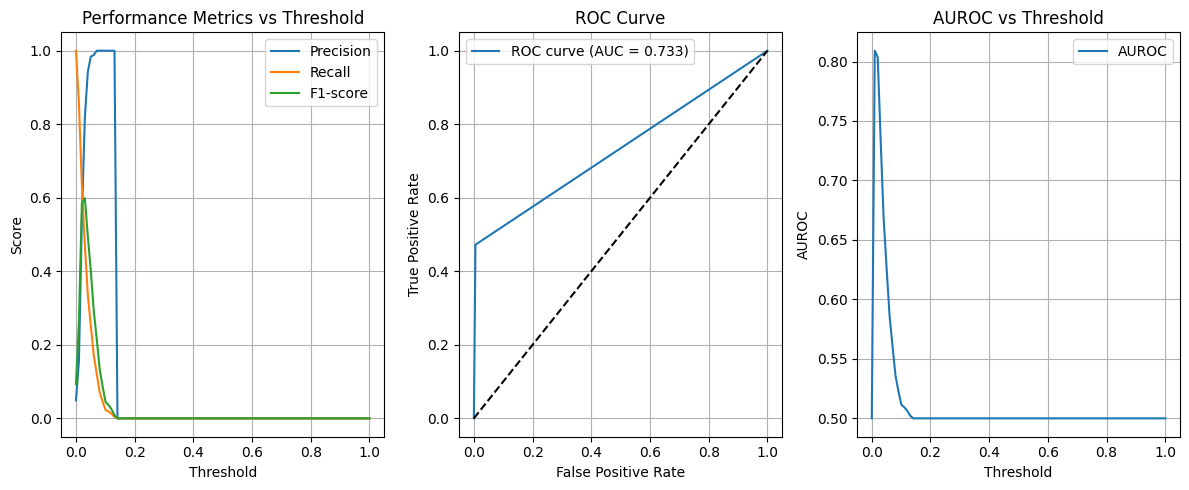

Best threshold: 0.030
Best F1-score: 0.599
AUROC: 0.733
Precision: 0.819
Recall: 0.472


In [16]:
# Plot performance metrics
plt.figure(figsize=(12, 5))

# Plot 1: Threshold-based metrics
plt.subplot(1, 3, 1)
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
plt.plot(metrics_df['threshold'], metrics_df['f1'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Threshold')
plt.legend()
plt.grid(True)

# Plot 2: ROC curve
plt.subplot(1, 3, 2)
best_idx = metrics_df['f1'].argmax()
best_metric = metrics_df.iloc[best_idx]
plt.plot(best_metric['fpr'], best_metric['tpr'], label=f'ROC curve (AUC = {best_metric["auroc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(metrics_df['threshold'], metrics_df['auroc'], label='AUROC')
plt.xlabel('Threshold')
plt.ylabel('AUROC')
plt.title('AUROC vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best metrics
print(f"Best threshold: {best_metric['threshold']:.3f}")
print(f"Best F1-score: {best_metric['f1']:.3f}")
print(f"AUROC: {best_metric['auroc']:.3f}")
print(f"Precision: {best_metric['precision']:.3f}")
print(f"Recall: {best_metric['recall']:.3f}")